In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from cellpose import models

base_dir_1 = Path('F:/')
base_dir_2 = Path('D:/')
mice = [25,27,30,36,39,52]
planes = range(1,9)

In [38]:
def get_cp_masks(ops, images=None, model_type='cyto', diameter=13, channels=[0,0]):
    model = models.CellposeModel(gpu=True, model_type=model_type)
    
    if images is None:
        mean_img = ops['meanImg']
        meanE_img = ops['meanImgE']
        max_img = ops['max_proj']
        
        mean_mask = model.eval(mean_img, channels=channels, diameter=diameter)[0]
        mean_mask[mean_mask>0] += 10
        meanE_mask = model.eval(meanE_img, channels=channels, diameter=diameter)[0]
        meanE_mask[meanE_mask>0] += np.max(mean_mask) + 10
        max_mask = model.eval(max_img, channels=channels, diameter=diameter)[0]
        max_mask[max_mask>0] += np.max(meanE_mask) + 10

        if max_img.shape != mean_img.shape:
            temp_max_max = np.zeros_like(mean_img)
            yrange = ops['yrange']
            xrange = ops['xrange']
            temp_max_max[yrange[0]:yrange[1], xrange[0]:xrange[1]] = max_mask
            max_mask = temp_max_max

        return mean_mask, meanE_mask, max_mask
    else:
        if images == 'mean':
            img = ops['meanImg']
        elif images == 'meanE':
            img = ops['meanImgE']
        elif images == 'max':
            img = ops['max_proj']
        mask = model.eval(img, channels=channels, diameter=diameter)[0]
        mask[mask>0] += 10
        return mask

def get_filtered_mask(mask, mouse, dendrite_threshold):
    if mouse < 31:
        pix_size = 0.7  # in microns
    else:
        pix_size = 0.82  # in microns

    filtering_pixel = (dendrite_threshold / pix_size / 2) ** 2 * np.pi

    mask_filtered = mask.copy()
    roi_nums = np.setdiff1d(np.unique(mask),0)
    for i in roi_nums:
        if np.sum(mask == i) < filtering_pixel:
            mask_filtered[mask == i] = 0
    return mask_filtered

def draw_contours(ax, mask, img=None, colors='r', linewidths=1, alpha=1):
    if img is None:
        img = mask > 0
    ax.imshow(img, cmap='gray')
    mask_inds = np.setdiff1d(np.unique(mask), 0)
    for i in mask_inds:
        temp_mask = mask == i
        ax.contour(temp_mask, colors=colors, linewidths=linewidths, alpha=alpha)

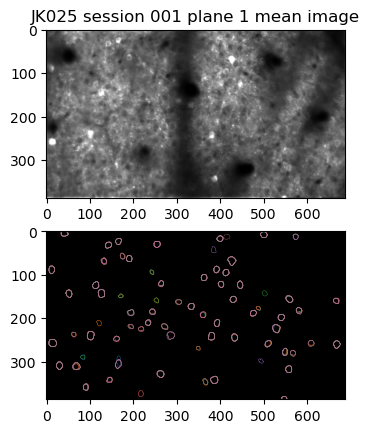

In [12]:
# test on meanImge, JK025, session 1, plane 4
mouse = 25
session = 1
plane = 1
image_type = 'mean'

base_dir = base_dir_1 if mouse < 31 else base_dir_2
diameter_range = np.arange(10,18) if mouse < 31 else np.arange(8,16)
dendrite_threshold = 6 if image_type == 'max' else 5

ops = np.load(f'{base_dir}{mouse:03}/plane_{plane}/{session:03d}/plane0/ops.npy', allow_pickle=True).item()

mask_list = []
for diameter in diameter_range:
    mask = get_cp_masks(ops, images=image_type, diameter=diameter)
    mask = get_filtered_mask(mask, mouse, dendrite_threshold)
    mask_list.append(mask)



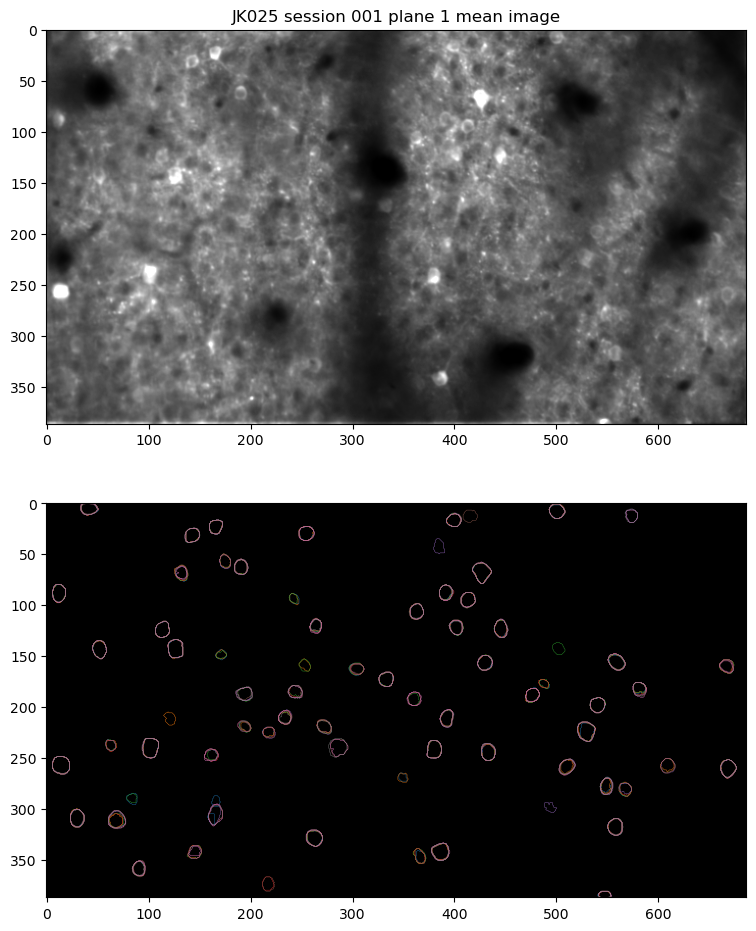

In [13]:
mimg = ops['meanImg']
mimg = np.clip(mimg, np.percentile(mimg,0.2), np.percentile(mimg,99.8))

fig, ax = plt.subplots(2,1, figsize=(10, 10*mimg.shape[0]*2/mimg.shape[1]))
ax[0].imshow(mimg, cmap='gray')
ax[0].set_title(f'JK{mouse:03} session {session:03} plane {plane} mean image')
blank_img = np.zeros(mimg.shape)
for i in range(len(mask_list)):
    draw_contours(ax[1], mask_list[i], img=blank_img, colors=f'C{i}', linewidths=0.3)

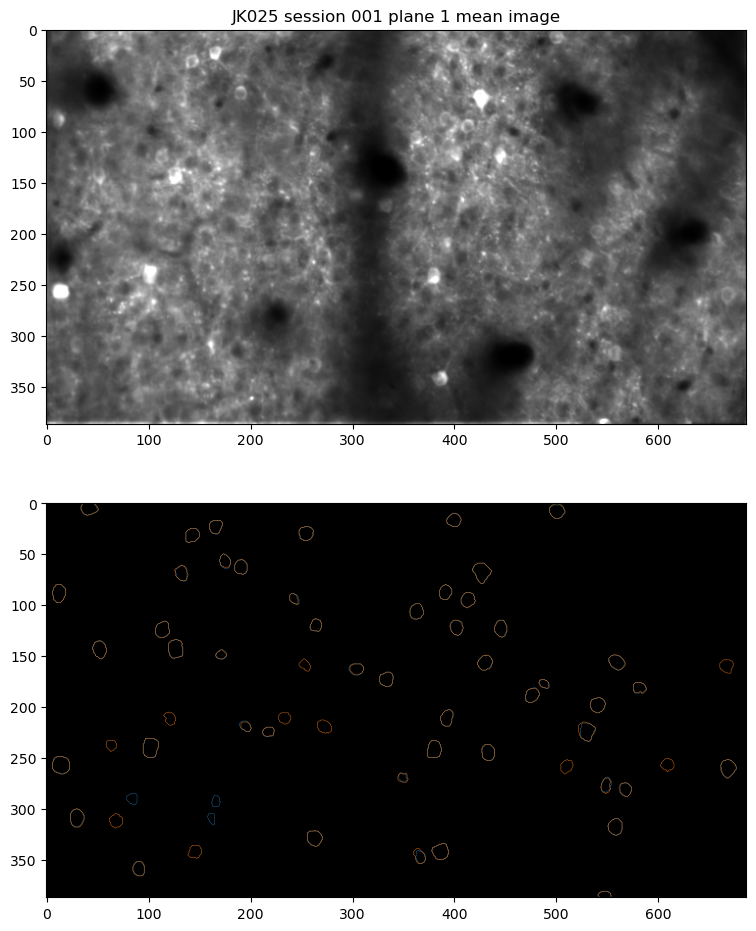

In [14]:
fig, ax = plt.subplots(2,1, figsize=(10, 10*mimg.shape[0]*2/mimg.shape[1]))
ax[0].imshow(mimg, cmap='gray')
ax[0].set_title(f'JK{mouse:03} session {session:03} plane {plane} mean image')
blank_img = np.zeros(mimg.shape)
for i in range(2):
    draw_contours(ax[1], mask_list[i], img=blank_img, colors=f'C{i}', linewidths=0.3)

In [36]:
(save_dir / save_fn).exists()

True

In [37]:
# save the figures from example sessions (1 and 15)
   
save_dir = Path(r'C:\Users\shires\Dropbox\Works\Projects\2020 Neural stretching in S1\Analysis\cellpose_mask_test')

mask_list = []
for diameter in diameter_range:
    mask = get_cp_masks(ops, images=image_type, diameter=diameter)
    mask = get_filtered_mask(mask, mouse, dendrite_threshold)
    mask_list.append(mask)
for mouse in mice:
    base_dir = base_dir_1 if mouse < 31 else base_dir_2
    diameter_range = np.arange(10,18) if mouse < 31 else np.arange(8,16)
    for session in [1, 15]:
        for plane in planes:
            # Test if it was run
            save_fn = f'masks_{mouse:03}_{session:03}_{plane:03}.npy'
            if not (save_dir / save_fn).exists():
                ops = np.load(f'{base_dir}{mouse:03}/plane_{plane}/{session:03d}/plane0/ops.npy', allow_pickle=True).item()
                mean_mask_list=[]
                meanE_mask_list=[]
                max_mask_list=[]
                for diameter in diameter_range:
                    mean_mask, meanE_mask, max_mask = get_cp_masks(ops, images=None, diameter=diameter)
                    for image_type in ['mean', 'meanE', 'max']:
                        dendrite_threshold = 6 if image_type == 'max' else 5
                        if image_type == 'meanE':
                            temp_mask = meanE_mask
                            filtered_mask = get_filtered_mask(temp_mask, mouse, dendrite_threshold)
                            meanE_mask_list.append(filtered_mask)
                        elif image_type == 'mean':
                            temp_mask = mean_mask
                            filtered_mask = get_filtered_mask(temp_mask, mouse, dendrite_threshold)
                            mean_mask_list.append(filtered_mask)
                        else:
                            temp_mask = max_mask
                            filtered_mask = get_filtered_mask(temp_mask, mouse, dendrite_threshold)
                            max_mask_list.append(filtered_mask)
                
                # save the masks
                np.save(save_dir / save_fn, [mean_mask_list, meanE_mask_list, max_mask_list])

                # draw the mask overlap and save the figure
                
                for ops_image_type in ['meanImg', 'meanImgE', 'max_proj']:
                    temp_img = ops[ops_image_type]
                    if ops_image_type == 'meanImg':
                        temp_img = np.clip(temp_img, np.percentile(temp_img,0.2), np.percentile(temp_img,99.8))
                        mask_list = mean_mask_list
                    elif ops_image_type == 'meanImgE':
                        mask_list = meanE_mask_list
                    else:
                        temp_img = np.clip(temp_img, np.percentile(temp_img,0.2), np.percentile(temp_img,99.8))
                        mask_list = max_mask_list

                    fig, ax = plt.subplots(2,1, figsize=(10, 10*temp_img.shape[0]*2/temp_img.shape[1]))
                    ax[0].imshow(temp_img, cmap='gray')
                    ax[0].set_title(f'JK{mouse:03} session {session:03} plane {plane} {ops_image_type}')
                    blank_img = np.zeros(temp_img.shape)
                    for i in range(len(mask_list)):
                        draw_contours(ax[1], mask_list[i], img=blank_img, colors=f'C{i}', linewidths=0.3)
                    save_fn = f'masks_{mouse:03}_{session:03}_{plane:03}_{ops_image_type}.png'
                    fig.savefig(save_dir / save_fn, bbox_inches='tight')
                    plt.close(fig)



In [32]:
ops['yrange']

[2, 385]

In [30]:
ops['Lx']

687

In [24]:
ops['max_proj'].shape

(383, 685)

In [25]:
[mask.shape for mask in meanE_mask_list]

[(387, 687),
 (387, 687),
 (387, 687),
 (387, 687),
 (387, 687),
 (387, 687),
 (387, 687),
 (387, 687)]

In [33]:
if ops['max_proj'].shape != ops['meanImg'].shape:
    temp_max_proj = np.zeros(ops['meanImg'].shape)
    yrange = ops['yrange']
    xrange = ops['xrange']
    temp_max_proj[yrange[0]:yrange[1], xrange[0]:xrange[1]] = ops['max_proj']
    


In [20]:
masks = {'mean_mask_list': mean_mask_list,
         'meanE_mask_list': meanE_mask_list,
         'max_mask_list': max_mask_list}


[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 